

# OVERVIEW:


1. Data pre-processing
1. EDA
1. Creating a ratings matrix
1. Dimensionality reduction of ratings matrix using matrix factorization
1. Collaborative filtering using k-Nearest Neighbors
1. Content-based filtering using similarity matrix of genre data.




In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# DATA PREPROCESSING:

In [4]:
data_path = 'drive/My Drive/DATA/movie lens/'

ratings = pd.read_csv(data_path + 'ratings_v2.csv')
movies = pd.read_csv(data_path + 'movies_v2.csv')

ratings.shape, movies.shape

((100836, 4), (9742, 3))

In [5]:
ratings.columns = [i.lower() for i in ratings.columns]
ratings.head()

,userid,movieid,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies.columns = [i.lower() for i in movies.columns]
movies.head()

,movieid,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
genres_ = movies['genres'].apply(lambda x: [i.lower() for i in x.split("|")])
genres_

0       [adventure, animation, children, comedy, fantasy]
1                          [adventure, children, fantasy]
2                                       [comedy, romance]
3                                [comedy, drama, romance]
4                                                [comedy]
                              ...                        
9737                 [action, animation, comedy, fantasy]
9738                         [animation, comedy, fantasy]
9739                                              [drama]
9740                                  [action, animation]
9741                                             [comedy]
Name: genres, Length: 9742, dtype: object

In [8]:
title2 = [i[:-6].strip() for i in movies.title]
year = [i[-6:].strip()[1:-1] for i in movies.title]

title2[:5], year[:5]

(['Toy Story',
  'Jumanji',
  'Grumpier Old Men',
  'Waiting to Exhale',
  'Father of the Bride Part II'],
 ['1995', '1995', '1995', '1995', '1995'])

# df_movies:

In [9]:
df_movies = pd.DataFrame().assign(movieid = movies.movieid,
                                  title = title2,
                                  genre = genres_,
                                  year = year)

df_movies.head()

,movieid,title,genre,year
0,1,Toy Story,"[adventure, animation, children, comedy, fantasy]",1995
1,2,Jumanji,"[adventure, children, fantasy]",1995
2,3,Grumpier Old Men,"[comedy, romance]",1995
3,4,Waiting to Exhale,"[comedy, drama, romance]",1995
4,5,Father of the Bride Part II,[comedy],1995


# df_ratings

In [10]:
df_ratings = ratings.merge(df_movies, on='movieid').drop('timestamp', axis = 1)
df_ratings.sample(5)

,userid,movieid,rating,title,genre,year
35161,325,3994,4.0,Unbreakable,"[drama, sci-fi]",2000
3528,438,500,3.5,Mrs. Doubtfire,"[comedy, drama]",1993
71516,275,1120,4.0,"People vs. Larry Flynt, The","[comedy, drama]",1996
57977,266,551,2.0,"Nightmare Before Christmas, The","[animation, children, fantasy, musical]",1993
38098,509,7153,5.0,"Lord of the Rings: The Return of the King, The","[action, adventure, drama, fantasy]",2003


# DISTRIBUTION OF MOVIE RATINGS:

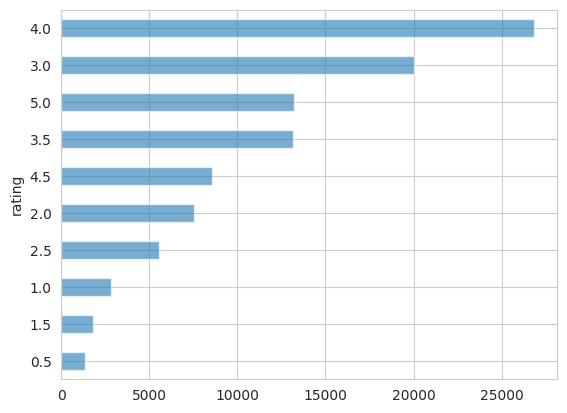

In [11]:
df_ratings.rating.value_counts()[::-1].plot(kind = 'barh', alpha = 0.6)
plt.show()

In [12]:
n_ratings = len(df_ratings)
n_movies = df_ratings['movieid'].nunique()
n_users = df_ratings['userid'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


In [13]:
print(f"Mean global rating: {round(df_ratings['rating'].mean(),2)}.")

mean_ratings = df_ratings.groupby('userid')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


# MOVIE RATINGS OVER THE YEARS:

In [14]:
rows = []
years = df_movies.year.unique()
error_years = []
for yr in years:

    try:
        df = df_ratings[df_ratings.year == yr]

        n_good_ratings = df[(df.rating >= 3) & (df.rating < 5)].shape[0]
        n_other_ratings = df[df.rating < 3].shape[0]
        n_5star_ratings = df[df.rating == 5].shape[0]
        n_movies = df.movieid.unique().shape[0]

        rows.append([int(yr), n_good_ratings, n_other_ratings, n_5star_ratings, n_movies])

    except:
        error_years.append(yr)


columns = 'year n_good_ratings n_other_ratings n_5star_ratings n_movies'.split()
df_time = pd.DataFrame(np.array(rows), columns = columns)

df_time.head()

,year,n_good_ratings,n_other_ratings,n_5star_ratings,n_movies
0,1995,4101,1145,897,258
1,1994,3450,931,915,237
2,1996,2971,994,544,276
3,1976,312,40,71,44
4,1992,1308,468,237,167


In [15]:
def fn_plot_singlex_multiy(singlex, multiy, single_x_label, multiy_labels,
                           alpha = 0.75, fontsize = 9,
                           figsize = (8, 5)):
    x = singlex
    plt.figure(figsize = figsize)
    for idx, y in enumerate(multiy):

        plt.plot(x, y, label = multiy_labels[idx], alpha = alpha)

    plt.legend(fontsize = fontsize)
    plt.xlabel(single_x_label, fontsize = fontsize, weight = 'bold')
    plt.xticks(fontsize = fontsize, rotation = 75)
    plt.yticks(fontsize = fontsize)
    plt.tight_layout()

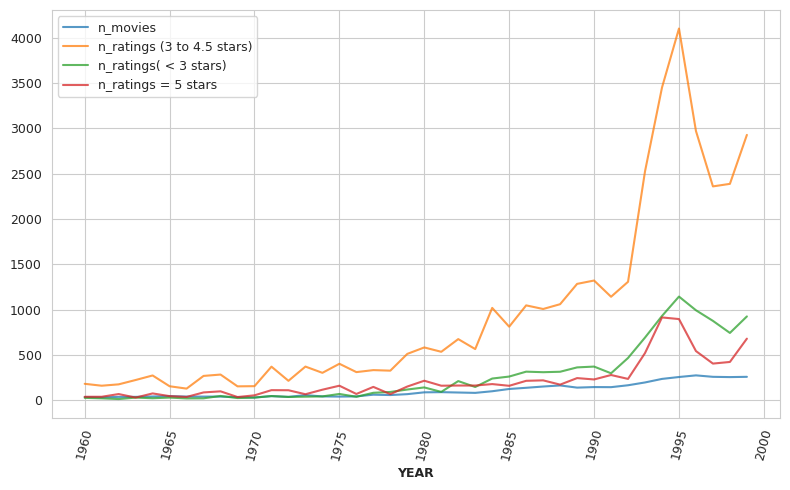

In [16]:
df = df_time[(df_time.year >= 1960) & (df_time.year < 2000)].sort_values('year')

# X_data & Y_datas:
singlex = df.year
y1 = df.n_movies
y2 = df.n_good_ratings
y3 = df.n_other_ratings
y4 = df.n_5star_ratings
multiy = [y1,y2,y3,y4]

# X_label & Y_labels:
single_x_label = 'YEAR'
l1 = 'n_movies'
l2 = 'n_ratings (3 to 4.5 stars)'
l3 = 'n_ratings( < 3 stars)'
l4 = 'n_ratings = 5 stars'
multiy_labels = [l1, l2, l3, l4]

fn_plot_singlex_multiy(singlex, multiy, single_x_label, multiy_labels)

# TOP 10 MOST FREQUENTLY RATED MOVIES:

In [17]:
df_ratings['title'].value_counts()[:10]

title
Forrest Gump                          329
Shawshank Redemption, The             317
Pulp Fiction                          307
Silence of the Lambs, The             279
Matrix, The                           278
Star Wars: Episode IV - A New Hope    251
Jurassic Park                         238
Braveheart                            237
Terminator 2: Judgment Day            224
Schindler's List                      220
Name: count, dtype: int64

##### BAYESIAN AVERAGE   
Avg rating that takes into account the n_ratings:

[Bayesian Average](https://en.wikipedia.org/wiki/Bayesian_average) is defined as:

$ r_{i} = \frac{ c \times m + \Sigma_{i}  {\text{reviews}}  } {c+n} $

where:   
$r_{i}$ : Bayesian rating for movie i.  
$c$ : average n_ratings per movie.  
$m$ : average rating per movie.    
$n$ : total number of reviews for movie $i$.   



In [18]:
movie_stats = df_ratings.groupby('movieid')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieid,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [19]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [20]:
def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

In [21]:
bayes_ratings = df_ratings.groupby('movieid')['rating'].agg(bayesian_avg)
bayes_ratings = bayes_ratings.sort_values(ascending = False)
bayes_ratings

movieid
318     4.392
858     4.236
2959    4.227
260     4.193
50      4.191
        ...  
2643    2.307
1499    2.297
1882    2.267
3593    2.224
1556    2.190
Name: rating, Length: 9724, dtype: float64

# TOP 10 RATED MOVIES:

In [22]:
df_movies.set_index('movieid').loc[bayes_ratings.index[:10]]

,title,genre,year
movieid,,,
318,"Shawshank Redemption, The","[crime, drama]",1994
858,"Godfather, The","[crime, drama]",1972
2959,Fight Club,"[action, crime, drama, thriller]",1999
260,Star Wars: Episode IV - A New Hope,"[action, adventure, sci-fi]",1977
50,"Usual Suspects, The","[crime, mystery, thriller]",1995
1221,"Godfather: Part II, The","[crime, drama]",1974
527,Schindler's List,"[drama, war]",1993
58559,"Dark Knight, The","[action, crime, drama, imax]",2008
1213,Goodfellas,"[crime, drama]",1990


# BOTTOM 10 RATED MOVIES:

In [23]:
df_movies.set_index('movieid').loc[bayes_ratings.index[-10:]]

,title,genre,year
movieid,,,
2701,Wild Wild West,"[action, comedy, sci-fi, western]",1999
8666,Catwoman,"[action, crime, fantasy]",2004
2798,Problem Child,"[children, comedy]",1990
5323,Jason X,"[horror, sci-fi, thriller]",2002
1760,Spice World,[comedy],1997
2643,Superman IV: The Quest for Peace,"[action, adventure, sci-fi]",1987
1499,Anaconda,"[action, adventure, thriller]",1997
1882,Godzilla,"[action, sci-fi, thriller]",1998
3593,Battlefield Earth,"[action, sci-fi]",2000


# TYPES OF GENRE AND THEIR DISTRIBUTION:

In [24]:
from collections import Counter

genre_frequency = Counter(g for genres in df_ratings.genre for g in genres)
len(genre_frequency)

20

<Axes: ylabel='genre'>

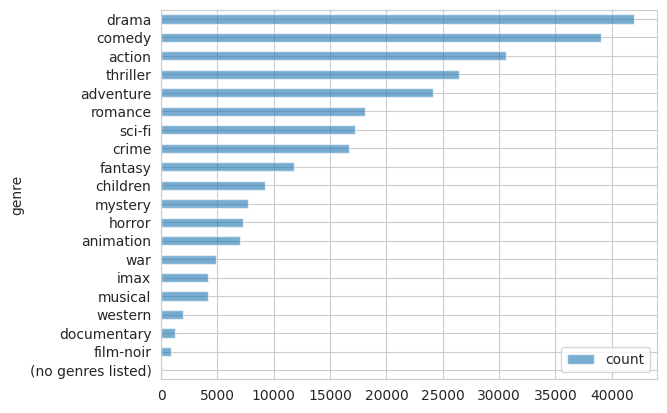

In [25]:
df_genre_frequency = pd.DataFrame().assign(genre = genre_frequency.keys(),
                                           count = genre_frequency.values())
df_genre_frequency.set_index('genre').sort_values(by = 'count').plot(kind = 'barh', alpha = 0.6)

# CREATING A UTILITY (RATINGS) MATRIX:

We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things.

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.



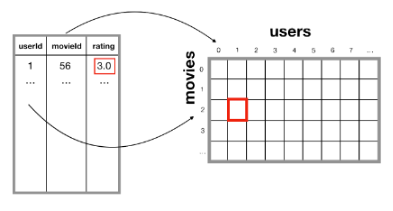

The `create_X()` function outputs a sparse matrix $X$ with four mapper dictionaries:

- **user_mapper**: maps user id to user index
- **movie_mapper**: maps movie id to movie index
- **user_inv_mapper**: maps user index to user id
- **movie_inv_mapper**: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our $X$ (user-item) matrix is a [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) which stores the data sparsely.

In [26]:
from scipy.sparse import csr_matrix

def f_ratings_matrix(df_ratings):
    """
    Generates a sparse matrix from ratings dataframe.
    Rows represent movies
    Columns represent users
    Each cell represents a rating given by a user to a movie
    Cell value = 0 if no rating available
    """
    U, u = df_ratings['userid'].unique(), df_ratings['userid'].nunique()
    M, m = df_ratings['movieid'].unique(), df_ratings['movieid'].nunique()

    user2idx_map = dict(zip(U, range(u)))
    idx2user_map = dict(zip(range(u), U))

    movie2idx_map = dict(zip(M, range(m)))
    idx2movie_map = dict(zip(range(m), M))

    user_index = [user2idx_map[i] for i in df_ratings['userid']]
    item_index = [movie2idx_map[i] for i in df_ratings['movieid']]

    ratings_matrix = csr_matrix((df_ratings["rating"], (item_index, user_index)), shape=(m, u))

    return ratings_matrix, user2idx_map, movie2idx_map, idx2user_map, idx2movie_map

In [27]:
z = f_ratings_matrix(df_ratings)
ratings_matrix, user2idx_map, movie2idx_map, idx2user_map, idx2movie_map = z

ratings_matrix.shape

(9724, 610)

In [28]:
len(idx2movie_map.keys())

9724

In [29]:
ratings_matrix

<9724x610 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [30]:
ratings_matrix.A

array([[4. , 4. , 4.5, ..., 0. , 0. , 0. ],
       [4. , 0. , 0. , ..., 0. , 0. , 0. ],
       [4. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

Our `X` matrix contains 9724 movies and 610 users.

### EVALUATING SPARCITY:

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix ([nnz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html)) is equivalent to the number of ratings in our dataset.

In [31]:
n_total = ratings_matrix.shape[0]*ratings_matrix.shape[1]
n_ratings = ratings_matrix.nnz # counts the stored values in our sparse matrix
sparsity = n_ratings/n_total

sparsity

0.016999683055613623

#  DIMENSIONAL REDUCTION USING MATRIX FACTORIZATION:

Matrix factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

We are reducing the dimensions of our original matrix into "latent" dimensions. We cannot interpret what each latent feature $k$ represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 1990s, while another latent feature may represent movies which are independent foreign language films.


In [32]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, n_iter=10)
Q = svd.fit_transform(ratings_matrix)

Q.shape

(9724, 50)

In [33]:
Q[:10, :5].round(2)

array([[ 3.765e+01, -6.380e+00,  1.499e+01,  2.900e-01, -1.890e+00],
       [ 8.500e+00, -5.710e+00,  3.440e+00, -6.380e+00,  2.000e-02],
       [ 2.141e+01, -6.960e+00,  6.640e+00,  1.930e+00,  6.290e+00],
       [ 3.906e+01, -2.290e+00,  1.651e+01,  9.560e+00, -4.500e-01],
       [ 3.942e+01, -6.560e+00,  1.081e+01,  1.723e+01,  5.500e-01],
       [ 1.376e+01, -9.300e-01, -1.190e+00,  2.400e-01,  5.690e+00],
       [ 7.640e+00, -3.010e+00, -5.050e+00, -1.340e+00,  0.000e+00],
       [ 3.794e+01, -1.242e+01,  2.898e+01,  4.650e+00,  9.600e-01],
       [ 6.790e+00, -5.440e+00,  5.490e+00, -3.730e+00, -1.580e+00],
       [ 2.870e+00, -1.860e+00, -1.660e+00, -1.070e+00, -1.400e-01]])

# COLLABORATIVE FILTERING BASED RECOMMENDATION:

We are going to find the $k$ movies that have the most similar user engagement vectors for movie $i$.

In [34]:
! pip install fuzzywuzzy

In [35]:
from fuzzywuzzy import process

def f_movieid(movie_name):
    all_movie_names = df_movies['title'].tolist()
    closest_match = process.extractOne(movie_name, all_movie_names)
    row = df_movies[df_movies.title == closest_match[0]]
    return row.iloc[0].movieid

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [36]:
f_movieid('scarface')

4262

In [52]:
def cf_recommender(movie_name, knn, ratings_matrix_, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    """

    movieid = f_movieid(movie_name)

    movie_idx = movie2idx_map[movieid]
    movie_vec = ratings_matrix_[movie_idx].reshape(1, -1)

    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)

    neighbor_idxs = knn.kneighbors(movie_vec, return_distance=False).flatten()
    movieids = [idx2movie_map[i] for i in neighbor_idxs][1:]

    movie_ = df_movies[df_movies.movieid == movieid].title.values[0]
    print(f'Becoz you watched: {movie_}:')
    print('---------------------------------')

    return df_movies.set_index('movieid').loc[movieids]

In [38]:
    from sklearn.neighbors import NearestNeighbors

    k = 5
    knn = NearestNeighbors(n_neighbors=k+1, algorithm="auto", metric='euclidean')
    knn.fit(Q)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

In [53]:
movie_name = 'toy story'
ratings_matrix_ = Q

cf_recommender(movie_name, knn, ratings_matrix_)

Becoz you watched: Toy Story:
---------------------------------


,title,genre,year
movieid,,,
780,Independence Day (a.k.a. ID4),"[action, adventure, sci-fi, thriller]",1996
648,Mission: Impossible,"[action, adventure, mystery, thriller]",1996
1073,Willy Wonka & the Chocolate Factory,"[children, comedy, fantasy, musical]",1971
3114,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",1999
1265,Groundhog Day,"[comedy, fantasy, romance]",1993


In [54]:
movie_name = 'jumanji'

cf_recommender(movie_name, knn, ratings_matrix_)

Becoz you watched: Jumanji:
---------------------------------


,title,genre,year
movieid,,,
19,Ace Ventura: When Nature Calls,[comedy],1995
586,Home Alone,"[children, comedy]",1990
317,"Santa Clause, The","[comedy, drama, fantasy]",1994
158,Casper,"[adventure, children]",1995
500,Mrs. Doubtfire,"[comedy, drama]",1993


In [55]:
movie_name = 'Singing in the Rain'

cf_recommender(movie_name, knn, ratings_matrix_)

Becoz you watched: Singin' in the Rain:
---------------------------------


,title,genre,year
movieid,,,
914,My Fair Lady,"[comedy, drama, musical, romance]",1964
915,Sabrina,"[comedy, romance]",1954
902,Breakfast at Tiffany's,"[drama, romance]",1961
1947,West Side Story,"[drama, musical, romance]",1961
916,Roman Holiday,"[comedy, drama, romance]",1953


# THE COLD START PROBLEM:

Collaborative filtering relies solely on user-item interactions within the utility  (ratings) matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the **cold start problem**.

Content-based filtering is a way to handle this problem by generating recommendations based on user and item features/metadata.

First, we need to convert the `genres` column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1.

In [42]:
genres_unique = set(g for G in df_movies['genre'] for g in G)

d = {}
for g in genres_unique:
    d[g] = [1 if g in i else 0 for i in df_movies.genre]

df_content = pd.DataFrame(d)
df_content.head()

,romance,children,thriller,comedy,sci-fi,documentary,musical,crime,adventure,western,film-noir,fantasy,war,drama,imax,(no genres listed),horror,action,mystery,animation
0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# SIMILARITY MATRIX:

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

simi_matrix = cosine_similarity(df_content)
simi_matrix.shape

(9742, 9742)

In [44]:
simi_matrix[:10, :5]

array([[1.        , 0.77459667, 0.31622777, 0.25819889, 0.4472136 ],
       [0.77459667, 1.        , 0.        , 0.        , 0.        ],
       [0.31622777, 0.        , 1.        , 0.81649658, 0.70710678],
       [0.25819889, 0.        , 0.81649658, 1.        , 0.57735027],
       [0.4472136 , 0.        , 0.70710678, 0.57735027, 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.31622777, 0.        , 1.        , 0.81649658, 0.70710678],
       [0.63245553, 0.81649658, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.25819889, 0.33333333, 0.        , 0.        , 0.        ]])

# CONTENT BASED RECOMMENDER:

In [45]:
def f_content_based_recommender(movie_name):

    idx_movieid_map = dict(zip(range(len(df_movies)), df_movies.movieid))
    movieid_idx_map = dict(zip(df_movies.movieid, range(len(df_movies))))

    movieid = f_movieid(movie_name)
    movie_idx = movieid_idx_map[movieid]
    sorted_idxs = simi_matrix[movie_idx].argsort()[::-1]
    closest_movies_ids = [idx_movieid_map[i] for i in sorted_idxs]

    movie_title = df_movies.set_index('movieid').loc[movieid].title
    print(f'Becoz you watched: {movie_title}')
    print('-----------------------------------')
    return df_movies.set_index('movieid').loc[closest_movies_ids[1:6]]

In [46]:
movie_name = 'Toy'

f_content_based_recommender(movie_name)

Becoz you watched: Toy Story
-----------------------------------


,title,genre,year
movieid,,,
103755,Turbo,"[adventure, animation, children, comedy, fantasy]",2013
4886,"Monsters, Inc.","[adventure, animation, children, comedy, fantasy]",2001
166461,Moana,"[adventure, animation, children, comedy, fantasy]",2016
4016,"Emperor's New Groove, The","[adventure, animation, children, comedy, fantasy]",2000
3754,"Adventures of Rocky and Bullwinkle, The","[adventure, animation, children, comedy, fantasy]",2000


In [47]:
movie_name = 'singing in the rain'

f_content_based_recommender(movie_name)

Becoz you watched: Singin' in the Rain
-----------------------------------


,title,genre,year
movieid,,,
6732,"Hello, Dolly!","[comedy, musical, romance]",1969
3606,On the Town,"[comedy, musical, romance]",1949
26680,Cry-Baby,"[comedy, musical, romance]",1990
3549,Guys and Dolls,"[comedy, musical, romance]",1955
7132,"Night at the Opera, A","[comedy, musical, romance]",1935


In [48]:
movie_name = 'scarface'

f_content_based_recommender(movie_name)

Becoz you watched: Scarface
-----------------------------------


,title,genre,year
movieid,,,
109569,3 Days to Kill,"[action, crime, drama]",2014
2194,"Untouchables, The","[action, crime, drama]",1987
3430,Death Wish,"[action, crime, drama]",1974
36931,New Police Story (Xin jing cha gu shi),"[action, crime, drama]",2004
384,Bad Company,"[action, crime, drama]",1995
